<a href="https://colab.research.google.com/github/learnerwcl/colab/blob/main/AttentionTrial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

In [ ]:
nn.Parameter(torch.rand((1,), requires_grad=True))

Parameter containing:
tensor([0.7660], requires_grad=True)

In [206]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [207]:
from matplotlib import pyplot as plt

def plot_kernel_reg(y_hat):
    plt.plot(x_test, y_truth)
    plt.plot(x_test, y_hat)
    plt.legend(['Truth', 'Pred'])
    plt.xlim([0, 5])
    plt.ylim([-1, 5])
    plt.plot(x_train, y_train, 'o', alpha=0.5)

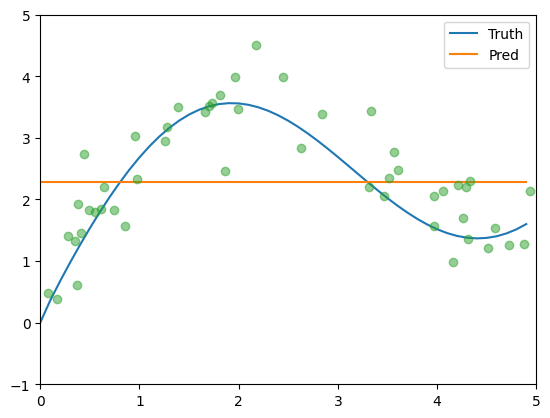

In [208]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

In [209]:
x_repeat = torch.repeat_interleave(x_test, x_train.shape[0]).reshape((-1, x_train.shape[0]))
x_attention = torch.softmax(-0.5*(x_repeat - x_train)**2, 1)
# 注意这里用的是 *，点乘
y_hat = torch.sum(x_attention * y_train, 1)

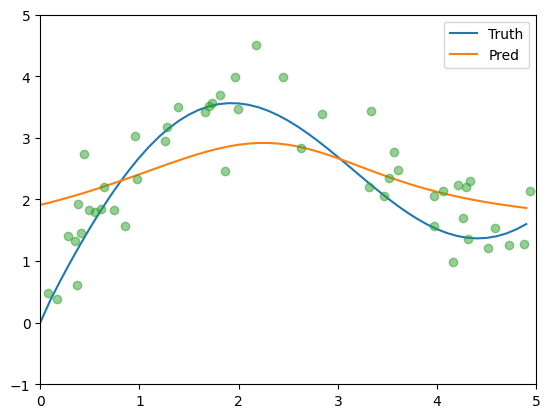

In [210]:
plot_kernel_reg(y_hat)

In [211]:
x_repeat = torch.repeat_interleave(x_test, x_train.shape[0]).reshape((-1, x_train.shape[0]))
x_attention = torch.softmax(-0.5*20*(x_repeat - x_train)**2, 1)
y_hat = torch.sum(x_attention * y_train, 1)

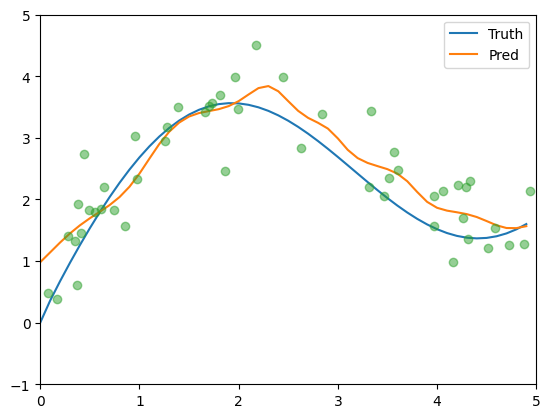

In [212]:
plot_kernel_reg(y_hat)

In [213]:
x_repeat = torch.repeat_interleave(x_test, x_train.shape[0]).reshape((-1, x_train.shape[0]))
x_attention = torch.softmax(-0.5*100*(x_repeat - x_train)**2, 1)
y_hat = torch.sum(x_attention * y_train, 1)

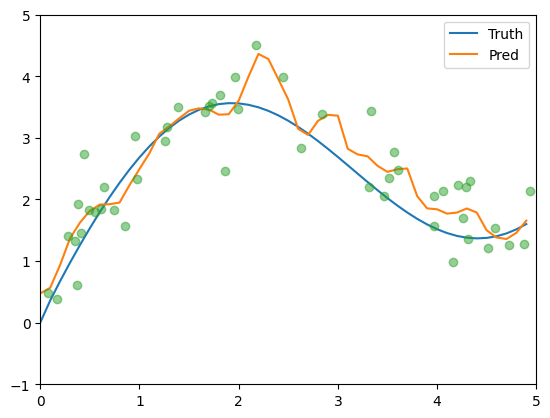

In [214]:
plot_kernel_reg(y_hat)

In [215]:
class attentionNadarayaWatson(nn.Module):
  def __init__(self):
    super(attentionNadarayaWatson, self).__init__()
    self.weight = nn.Parameter(torch.ones((1,)), requires_grad=True)

  def forward(self, queries, keys, values):
    repeat_ = torch.repeat_interleave(queries, keys.shape[1]).reshape((-1, keys.shape[1]))
    attention_ = torch.softmax(-0.5*(self.weight*(repeat_ - keys))**2, 1)
    return torch.sum(attention_ * values, 1)

In [216]:
# 构造训练样本
# 训练样本需要注意的是，入模训练的时候，需要把自己给mask掉

X_ = x_train.repeat((x_train.shape[0], 1))
Y_ = y_train.repeat((x_train.shape[0], 1))

keys = X_[(1 - torch.eye(x_train.shape[0])).type(torch.bool)].reshape(x_train.shape[0], -1)
values = Y_[(1 - torch.eye(x_train.shape[0])).type(torch.bool)].reshape(x_train.shape[0], -1)

In [238]:
net = attentionNadarayaWatson()
loss = torch.nn.MSELoss(reduction='sum')
# opt = torch.optim.SGD(net.parameters(), lr=0.5)
opt =  torch.optim.Adam(net.parameters(), lr=0.3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 设置设备

In [239]:
for epoch in range(10):
  opt.zero_grad()
  y_hat_ = net(x_train, keys, values)
  loss_ = loss(y_hat_, y_train)
  loss_.backward()
  opt.step()

tensor(24.6876)
tensor(18.7134)
tensor(15.6902)
tensor(14.1863)
tensor(13.3722)
tensor(12.8743)
tensor(12.5336)
tensor(12.2784)
tensor(12.0736)
tensor(11.9009)


In [240]:
for para_ in net.parameters():
  print(para_)

Parameter containing:
tensor([3.1055], requires_grad=True)


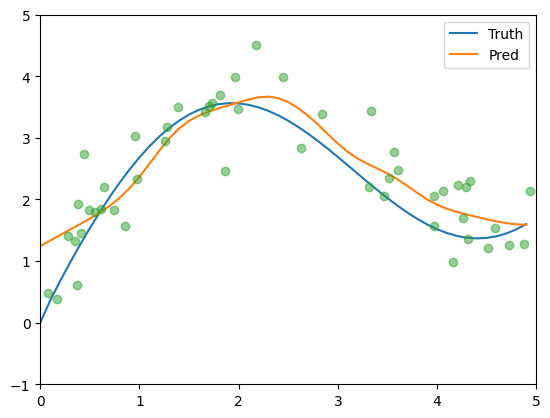

In [242]:
net.eval()

keys = X_.reshape(x_test.shape[0], -1)
values = Y_.reshape(x_test.shape[0], -1)

y_hat = net(x_test, keys, values).detach()

plot_kernel_reg(y_hat)

In [296]:
class attentionNadarayaWatsonPro(nn.Module):
  def __init__(self, n_train):
    super(attentionNadarayaWatsonPro, self).__init__()
    self.weight = nn.Parameter(torch.rand((n_train,1)), requires_grad=True)

  def forward(self, queries, keys, values):
    repeat_ = torch.repeat_interleave(queries, keys.shape[1]).reshape((-1, keys.shape[1]))
    attention_ = torch.softmax(-0.5*self.weight*((repeat_ - keys))**2, 1)
    return torch.sum(attention_ * values, 1)


In [297]:
# 构造训练样本
# 训练样本需要注意的是，入模训练的时候，需要把自己给mask掉

X_ = x_train.repeat((x_train.shape[0], 1))
Y_ = y_train.repeat((x_train.shape[0], 1))

keys = X_[(1 - torch.eye(x_train.shape[0])).type(torch.bool)].reshape(x_train.shape[0], -1)
values = Y_[(1 - torch.eye(x_train.shape[0])).type(torch.bool)].reshape(x_train.shape[0], -1)

In [301]:
net = attentionNadarayaWatsonPro(x_train.shape[0])
loss = torch.nn.MSELoss(reduction='sum')
# opt = torch.optim.SGD(net.parameters(), lr=0.5)
opt =  torch.optim.Adam(net.parameters(), lr=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 设置设备

In [302]:
for epoch in range(5):
  opt.zero_grad()
  y_hat_ = net(x_train, keys, values)
  loss_ = loss(y_hat_, y_train)
  loss_.backward()
  opt.step()
  print(loss_)

tensor(33.8051, grad_fn=<MseLossBackward0>)
tensor(21.2973, grad_fn=<MseLossBackward0>)
tensor(16.2072, grad_fn=<MseLossBackward0>)
tensor(13.9310, grad_fn=<MseLossBackward0>)
tensor(12.6567, grad_fn=<MseLossBackward0>)


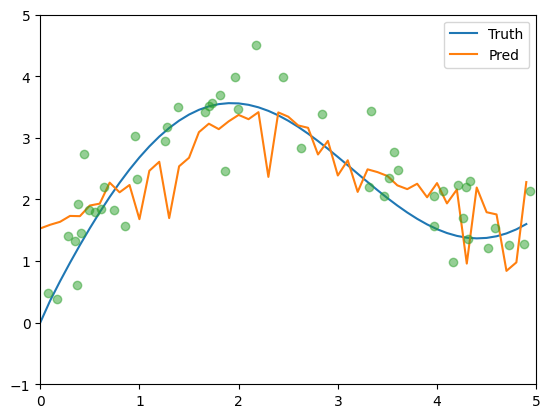

In [303]:
net.eval()

keys = X_.reshape(x_test.shape[0], -1)
values = Y_.reshape(x_test.shape[0], -1)

y_hat = net(x_test, keys, values).detach()

plot_kernel_reg(y_hat)